---
# 7. An End-to-End Classification Test
As the last step, you are given a dataset called `data/ccdefault.csv`. The dataset represents default of credit card clients. It has 30,000 cases and 24 different attributes. More details about the dataset is available at `data/ccdefault.txt`. In this task you should make three models, compare their results and conclude the ideal solution. Here are the suggested steps:
1. Load the data.
2. Carry out some exploratory analyses (e.g., how various features and the target variable are distributed).
3. Train a model to predict the target variable (risk of `default`).
  - Employ three different models (logistic regression, decision tree, and random forest).
  - Compare the models' performances (e.g., AUC).
  - Defend your choice of best model (e.g., what are the strength and weaknesses of each of these models?).
4. What more would you do with this data? Anything to help you devise a better solution?

## We'll do the first necessaty imports

In [1]:
import pyspark
import pandas as pd
from pyspark.sql import SparkSession

spark=SparkSession.builder.master("local").appName("monday_exam").getOrCreate()

## We'll get the data

In [21]:
ccdefault = spark.read.format('csv').options(header=True, inferSchema=True).load("data/ccdefault.csv")

## Some basic operations to understand the data

In [22]:
# See the schema of the data
ccdefault.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- LIMIT_BAL: integer (nullable = true)
 |-- SEX: integer (nullable = true)
 |-- EDUCATION: integer (nullable = true)
 |-- MARRIAGE: integer (nullable = true)
 |-- AGE: integer (nullable = true)
 |-- PAY_0: integer (nullable = true)
 |-- PAY_2: integer (nullable = true)
 |-- PAY_3: integer (nullable = true)
 |-- PAY_4: integer (nullable = true)
 |-- PAY_5: integer (nullable = true)
 |-- PAY_6: integer (nullable = true)
 |-- BILL_AMT1: integer (nullable = true)
 |-- BILL_AMT2: integer (nullable = true)
 |-- BILL_AMT3: integer (nullable = true)
 |-- BILL_AMT4: integer (nullable = true)
 |-- BILL_AMT5: integer (nullable = true)
 |-- BILL_AMT6: integer (nullable = true)
 |-- PAY_AMT1: integer (nullable = true)
 |-- PAY_AMT2: integer (nullable = true)
 |-- PAY_AMT3: integer (nullable = true)
 |-- PAY_AMT4: integer (nullable = true)
 |-- PAY_AMT5: integer (nullable = true)
 |-- PAY_AMT6: integer (nullable = true)
 |-- DEFAULT: integer (nullable = tru

In [23]:
ccdefault.show(5)

+---+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+-------+
| ID|LIMIT_BAL|SEX|EDUCATION|MARRIAGE|AGE|PAY_0|PAY_2|PAY_3|PAY_4|PAY_5|PAY_6|BILL_AMT1|BILL_AMT2|BILL_AMT3|BILL_AMT4|BILL_AMT5|BILL_AMT6|PAY_AMT1|PAY_AMT2|PAY_AMT3|PAY_AMT4|PAY_AMT5|PAY_AMT6|DEFAULT|
+---+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+-------+
|  1|    20000|  2|        2|       1| 24|    2|    2|   -1|   -1|   -2|   -2|     3913|     3102|      689|        0|        0|        0|       0|     689|       0|       0|       0|       0|      1|
|  2|   120000|  2|        2|       2| 26|   -1|    2|    0|    0|    0|    2|     2682|     1725|     2682|     3272|     3455|     3261|       0|    1000|    1000|    1000|       0|    2000|    

+---+---------+---+---------+--------+---+--------+-------+-------------------+------------------+------------------+
| ID|LIMIT_BAL|SEX|EDUCATION|MARRIAGE|AGE|PAY_AMT2|DEFAULT|            PAY_AVG|       PAY_AMT_AVG|          BILL_AVG|
+---+---------+---+---------+--------+---+--------+-------+-------------------+------------------+------------------+
|  1|    20000|  2|        2|       1| 24|     689|      1|-0.3333333333333333|114.83333333333333|            1284.0|
|  2|   120000|  2|        2|       2| 26|    1000|      1|                0.5| 833.3333333333334|2846.1666666666665|
|  3|    90000|  2|        2|       2| 34|    1500|      0|                0.0|1836.3333333333333|16942.166666666668|
|  4|    50000|  2|        2|       1| 37|    2019|      0|                0.0|            1398.0|38555.666666666664|
|  5|    50000|  1|        2|       1| 57|   36681|      0|-0.3333333333333333|            9841.5|18223.166666666668|
+---+---------+---+---------+--------+---+--------+-----

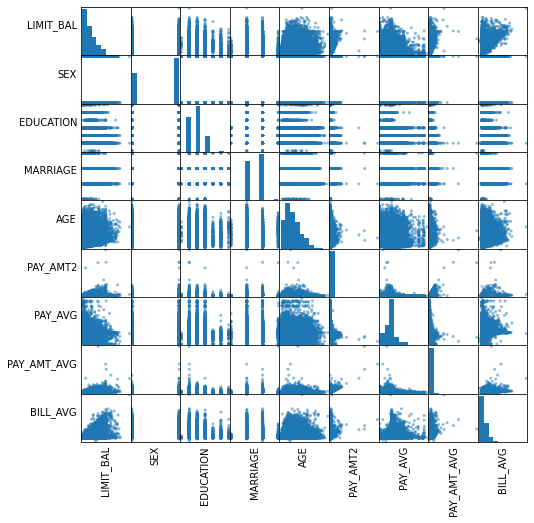

In [25]:
from pyspark.sql.functions import expr
from pandas.plotting import scatter_matrix

ccdefault_cleaned = ccdefault.withColumn("PAY_AVG", expr('(PAY_0 + PAY_2 + PAY_3 + PAY_4 + PAY_5 + PAY_6)/6'))
ccdefault_cleaned1 = ccdefault_cleaned.withColumn("PAY_AMT_AVG", expr('(PAY_AMT1 + PAY_AMT2 + PAY_AMT3 + PAY_AMT4 + PAY_AMT5 + PAY_AMT6)/6'))
ccdefault_cleaned2 = ccdefault_cleaned1.withColumn("BILL_AVG", expr('(BILL_AMT1 + BILL_AMT2 + BILL_AMT3 + BILL_AMT4 + BILL_AMT5 + BILL_AMT6)/6'))

ccdefault_cleaned_final = ccdefault_cleaned2.drop('PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
                                                  'PAY_AMT1',' PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4','PAY_AMT5', 'PAY_AMT6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6')
ccdefault_cleaned_final.show(5)
ccdefault_cleaned_final.write.csv('ccdefault_cleaned_final.csv', header=True)
numeric_data = ccdefault_cleaned_final.select([ x for x in ccdefault_cleaned_final.columns if x != 'DEFAULT' and x != 'ID']).toPandas()
axs = scatter_matrix(numeric_data, figsize=(8, 8))

n = len(numeric_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())


## Let's prepare the data for the machine learning algorithm

In [31]:
# Renamed the DEFAULT column to label
ccdefaultRenamed = ccdefault_cleaned_final.withColumnRenamed('DEFAULT', 'label')
# Select the columns without the label column
colAttr = [col for col in ccdefaultRenamed.columns if col != 'ID' and col != 'label']

## We can verify that the columns dont have missing values

In [32]:
for c in colAttr:
    count = ccdefaultRenamed.filter(
        c+" is   NULL" or c+"is ''" or c+"is  NaN" or c+"is  null").count()
    print(c+" column has " + str(count) + " missing values\n")


LIMIT_BAL column has 0 missing values

SEX column has 0 missing values

EDUCATION column has 0 missing values

MARRIAGE column has 0 missing values

AGE column has 0 missing values

PAY_AMT2 column has 0 missing values

PAY_AVG column has 0 missing values

PAY_AMT_AVG column has 0 missing values

BILL_AVG column has 0 missing values



## Now let's create our features vector

In [33]:
# First let's transform our attributes into a big vector
from pyspark.ml.feature import VectorAssembler

vectorAssembler = VectorAssembler(inputCols=colAttr, outputCol='features')  # to_be_scaled
ccdefaultFeatured = vectorAssembler.transform(ccdefaultRenamed)

ccdefaultFeatured.show(5)


+---+---------+---+---------+--------+---+--------+-----+-------------------+------------------+------------------+--------------------+
| ID|LIMIT_BAL|SEX|EDUCATION|MARRIAGE|AGE|PAY_AMT2|label|            PAY_AVG|       PAY_AMT_AVG|          BILL_AVG|            features|
+---+---------+---+---------+--------+---+--------+-----+-------------------+------------------+------------------+--------------------+
|  1|    20000|  2|        2|       1| 24|     689|    1|-0.3333333333333333|114.83333333333333|            1284.0|[20000.0,2.0,2.0,...|
|  2|   120000|  2|        2|       2| 26|    1000|    1|                0.5| 833.3333333333334|2846.1666666666665|[120000.0,2.0,2.0...|
|  3|    90000|  2|        2|       2| 34|    1500|    0|                0.0|1836.3333333333333|16942.166666666668|[90000.0,2.0,2.0,...|
|  4|    50000|  2|        2|       1| 37|    2019|    0|                0.0|            1398.0|38555.666666666664|[50000.0,2.0,2.0,...|
|  5|    50000|  1|        2|       1| 57

## Now let's create our model

In [34]:
# First we select the columns we need
dataset = ccdefaultFeatured.withColumn(
    colName="features", col=ccdefaultFeatured["features"])
dataset = ccdefaultFeatured.withColumn(
    colName="label", col=ccdefaultFeatured["label"])
# Then we create our train and test split
trainSet, testSet = dataset.randomSplit([0.7, 0.3])

trainSet.select("features").show(20, False)


+----------------------------------------------------------------------------------------+
|features                                                                                |
+----------------------------------------------------------------------------------------+
|[20000.0,2.0,2.0,1.0,24.0,689.0,-0.3333333333333333,114.83333333333333,1284.0]          |
|[90000.0,2.0,2.0,2.0,34.0,1500.0,0.0,1836.3333333333333,16942.166666666668]             |
|[50000.0,1.0,2.0,1.0,57.0,36681.0,-0.3333333333333333,9841.5,18223.166666666668]        |
|[50000.0,1.0,1.0,2.0,37.0,1815.0,0.0,1295.3333333333333,39685.666666666664]             |
|[500000.0,1.0,1.0,2.0,29.0,40000.0,0.0,30126.5,454099.1666666667]                       |
|[100000.0,2.0,2.0,2.0,23.0,601.0,-0.5,798.5,2247.6666666666665]                         |
|[20000.0,1.0,3.0,2.0,35.0,0.0,-1.6666666666666667,2354.8333333333335,4486.5]            |
|[200000.0,2.0,3.0,2.0,34.0,12.0,0.16666666666666666,1078.6666666666667,5744.5]          |

## 1- Logistic Regression

In [35]:
from pyspark.ml.classification import LogisticRegression
# We train the model
logisticRegression = LogisticRegression(maxIter = 100, regParam = 0, elasticNetParam=1)
model = logisticRegression.fit(trainSet)



# The summary of the learning process
trainingSummary = model.summary

print("Intercept: " + str(model.intercept)+"\n")

for i, v in enumerate(model.coefficients):  # l'importance
    print('Feature: %0d, Score: %.5f' % (i, v))

print(trainingSummary.accuracy)


Intercept: -0.3833628181449873

Feature: 0, Score: -0.00000
Feature: 1, Score: -0.11240
Feature: 2, Score: -0.08967
Feature: 3, Score: -0.19389
Feature: 4, Score: 0.00447
Feature: 5, Score: -0.00001
Feature: 6, Score: 0.69125
Feature: 7, Score: -0.00003
Feature: 8, Score: -0.00000
0.7973775476269657


+----------+-----+--------------------+
|prediction|label|            features|
+----------+-----+--------------------+
|       0.0|    1|[120000.0,2.0,2.0...|
|       0.0|    0|[50000.0,2.0,2.0,...|
|       0.0|    0|[140000.0,2.0,3.0...|
|       0.0|    0|[250000.0,1.0,1.0...|
|       0.0|    0|[50000.0,2.0,3.0,...|
|       0.0|    0|[320000.0,1.0,1.0...|
|       0.0|    0|[180000.0,2.0,1.0...|
|       0.0|    0|[130000.0,2.0,3.0...|
|       0.0|    0|[50000.0,1.0,3.0,...|
|       0.0|    1|[60000.0,1.0,1.0,...|
|       0.0|    0|[50000.0,2.0,3.0,...|
|       0.0|    0|[500000.0,1.0,1.0...|
|       0.0|    0|[60000.0,2.0,2.0,...|
|       0.0|    0|[10000.0,1.0,2.0,...|
|       0.0|    0|[180000.0,2.0,1.0...|
|       1.0|    1|[10000.0,1.0,2.0,...|
|       0.0|    0|[20000.0,1.0,2.0,...|
|       0.0|    0|[300000.0,2.0,1.0...|
|       0.0|    0|[130000.0,2.0,1.0...|
|       0.0|    0|[20000.0,1.0,3.0,...|
|       1.0|    1|[200000.0,1.0,1.0...|
|       0.0|    0|[280000.0,2.0,1.0...|


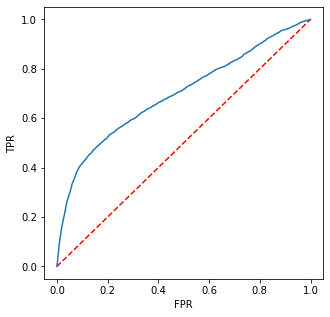

In [36]:
# Now we evaluate the model
import matplotlib.pyplot as plt
from pyspark.ml.evaluation import RegressionEvaluator

# Make the predictions on the test data
predictions = model.transform(testSet)
predictions.select("prediction", "label", "features").show(50)


# select (prediction, true label) and compute test error.
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(predictions.select(predictions["prediction"] == 1).count())
print("Root Mean Squared Error (RMSE) on test data = " + str(rmse))


plt.figure(figsize=(5, 5))
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(model.summary.roc.select('FPR').collect(),
         model.summary.roc.select('TPR').collect())
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()


## 2- Decision Tree

In [37]:
from pyspark.ml.regression import DecisionTreeRegressor

decisionTree = DecisionTreeRegressor(labelCol="label", featuresCol="features")

# train the model
model = decisionTree.fit(trainSet)


# make predictions on the test data
predictions = model.transform(testSet)
predictions.select("prediction", "label", "features").show(5)

# select (prediction, true label) and compute test error
evaluator =  RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Mean Squared Error (RMSE) on test data = "+ str(rmse))

+-------------------+-----+--------------------+
|         prediction|label|            features|
+-------------------+-----+--------------------+
|0.44545454545454544|    1|[120000.0,2.0,2.0...|
|0.17780360255665312|    0|[50000.0,2.0,2.0,...|
|0.44545454545454544|    0|[140000.0,2.0,3.0...|
|0.08758738952644769|    0|[250000.0,1.0,1.0...|
|0.44545454545454544|    0|[50000.0,2.0,3.0,...|
+-------------------+-----+--------------------+
only showing top 5 rows

Mean Squared Error (RMSE) on test data = 0.3751527983694745


## 3- Random Forest

In [38]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

randomForest = RandomForestRegressor(labelCol="label", featuresCol="features")

# train the model
model = randomForest.fit(trainSet)

# make predictions on the test data
predictions = model.transform(testSet)
predictions.select("prediction", "label", "features").show(25)

# select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = " + str(rmse))


+-------------------+-----+--------------------+
|         prediction|label|            features|
+-------------------+-----+--------------------+
|0.38479050203121967|    1|[120000.0,2.0,2.0...|
| 0.1654663705449407|    0|[50000.0,2.0,2.0,...|
|0.31995149648659665|    0|[140000.0,2.0,3.0...|
|0.09331596921337601|    0|[250000.0,1.0,1.0...|
| 0.3766082978611892|    0|[50000.0,2.0,3.0,...|
|0.09345898252678728|    0|[320000.0,1.0,1.0...|
|  0.311812338910736|    0|[180000.0,2.0,1.0...|
|0.11803234544988635|    0|[130000.0,2.0,3.0...|
|0.17176592952984174|    0|[50000.0,1.0,3.0,...|
| 0.2774758749730547|    1|[60000.0,1.0,1.0,...|
|0.15895364153961364|    0|[50000.0,2.0,3.0,...|
|0.10550430758099257|    0|[500000.0,1.0,1.0...|
|0.14197055819735216|    0|[60000.0,2.0,2.0,...|
|  0.197346835493509|    0|[10000.0,1.0,2.0,...|
| 0.2935637206067844|    0|[180000.0,2.0,1.0...|
| 0.5148851748304267|    1|[10000.0,1.0,2.0,...|
| 0.4199528226662862|    0|[20000.0,1.0,2.0,...|
|0.22395258502815563